In [5]:
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../../RKLM_Python/')
# Path to output files
sys.path.append('../')

import numpy as np
import utils
import plotting_tools as pt

from importlib import reload
import utils
utils = reload(utils)
pt = reload(pt)

from scipy import signal
import pickle

In [6]:
swe = False
euler = True
rb = False

# Plot format for MWR or arXiv?
MWR = True
arXiv = False

In [7]:
def load(base_fn,Nx,Ny,et,Nz=None):
    pydir = '../../%s/' %base_fn

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et, Nz=Nz)
    tags = tc.get_tag_dict()
    return tc, tags

if swe:
    base_fn = 'output_swe_vortex'
    Nx, Ny, Nz = 64, 1, 64
    et = 3.0
    tc, tags = load(base_fn,Nx,Ny,et,Nz)
    
    attr_labels = pt.swe_labels()
    attributes = ['rho','p2_nodes','rhou','rhow']
    obs_attrs = 'rhou_rhow'
    aux = 'wda'
    aux_ref = ''
    lbl = 'swe'
    times = np.arange(0.0,3.01,0.01)[1:]
    
    x_axs = [-0.5,0.0,0.5]
    y_axs = [-0.5,0.0,0.5]
    axs0, axs1 = Nx, Nz

elif euler:
    base_fn = "output_travelling_vortex"
    Nx, Ny = 64, 64
    et = 3.0
    tc, tags = load(base_fn,Nx,Ny,et)
    
    attr_labels = pt.labels()
    attributes = ['rho','rhoY','rhou','rhov']
    obs_attrs = 'rhou_rhov'
    aux = 'wda'
    aux_ref = ''
    lbl = 'euler'
    times = np.arange(0.0,3.01,0.01)[1:]
#     times = np.arange(0.0,3.01,0.01)[1:10]
    
    x_axs = [-0.5,0.0,0.5]
    y_axs = [-0.5,0.0,0.5]
    axs0, axs1 = Nx, Ny
    
elif rb:
    base_fn = "output_rising_bubble"
    Nx, Ny = 160,80
    et = 1.0
    tc, tags = load(base_fn,Nx,Ny,et)
    
    attr_labels = pt.labels()
    attributes = ['rho','rhoY','rhou','rhov']
    obs_attrs = 'rhou_rhov'
    aux = 'wda_CFLfixed'
    aux_ref = '_CFLfixed'
    lbl = 'rb'
    times = np.arange(1.0,10.1,0.1) / 10.0
    
    x_axs = [-10,-5,0.0,5,10]
    y_axs = [0.0,5.0,10.0]
    axs0, axs1 = Nx, Ny
    
ens_noda_suffix = 'noda%s_ib-0' %aux_ref
ens_noda_label = 'EnNoDA'

ens_1_suffix = 'wdawloc_%s_%s_ib-0' %(obs_attrs,aux)
ens_1_label = r'EnDA'
#     ens_1_label = r'Ens. w/ DA'

ens_2_suffix = tc.cb_suffix(1,0, '%s' %(ens_1_suffix))
ens_2_label = r'EnDAB'
#     ens_2_label = r'Ens. w/ DA+Blending'

if euler:
    ens_1_label += r', $\{ \rho u, \rho v \}$'
    ens_2_label += r', $\{ \rho u, \rho v \}$'

    obs_attrs_34 = 'all'
    ens_3_suffix = 'wdawloc_%s_%s_ib-0' %(obs_attrs_34,aux)
    ens_3_label = r'EnDA, $\{ \rho, \rho u, \rho v, \rho \Theta, \pi \}$'
    ens_4_suffix = tc.cb_suffix(1,0, '%s' %(ens_3_suffix))
    ens_4_label = r'EnDAB, $\{ \rho, \rho u, \rho v, \rho \Theta, \pi \}$'

# Ensemble size is the same across all test cases
N = 10

/home/ray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:137: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


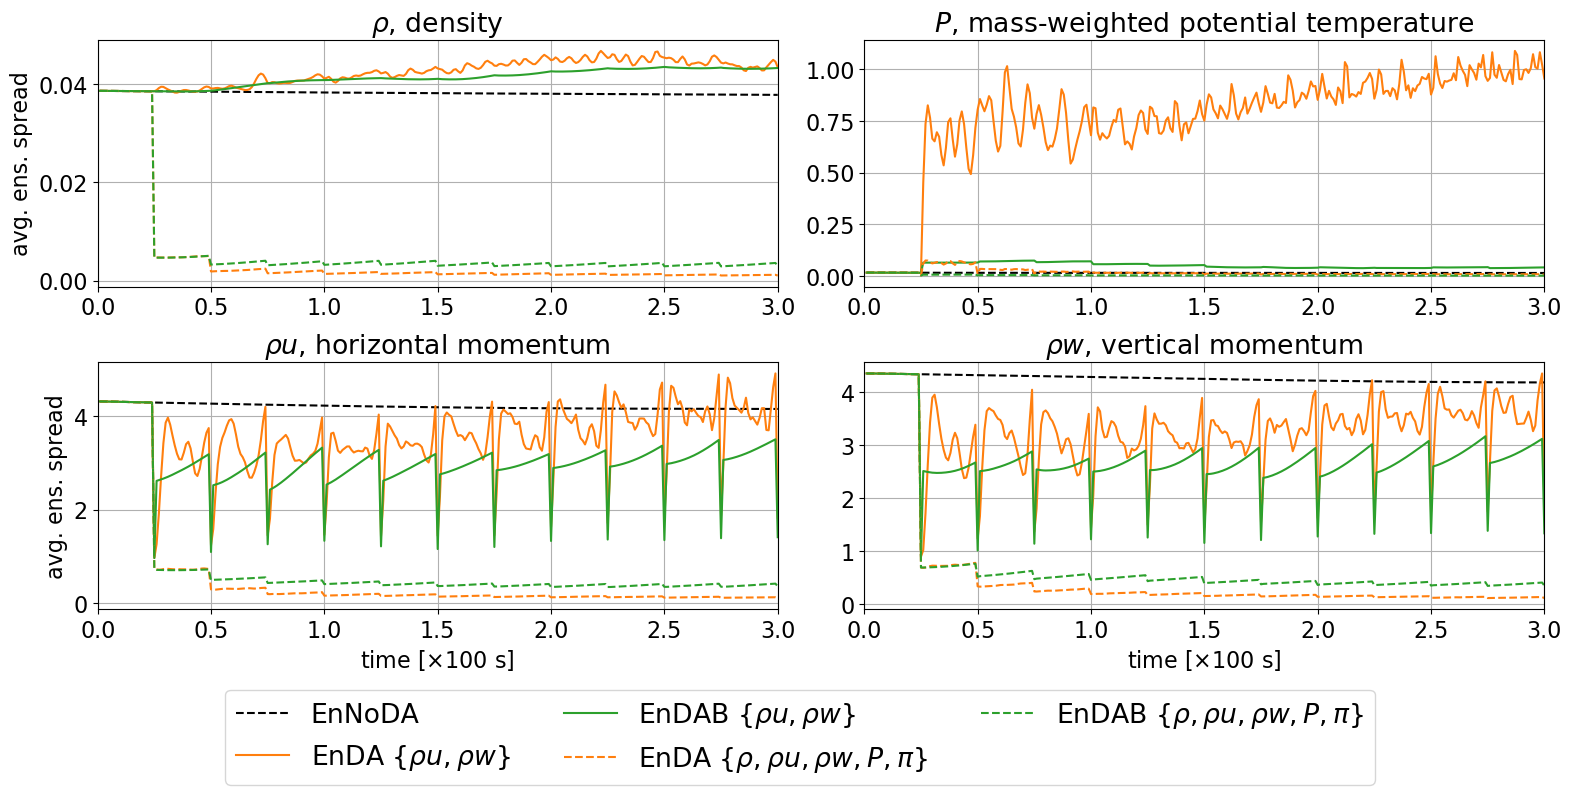

In [8]:
import matplotlib.pyplot as plt

plt.style.use('default')

fs = (16,8) # MWR and arXiv
nrows = 2
if MWR:
    pl = pt.plotter_1d(figsize=fs,fontsize=16,ncols=2,nrows=nrows)
elif arXiv:
    pl = pt.plotter_1d(figsize=fs,fontsize=16,ncols=2,nrows=nrows)

def ic_loader(tc, N, sfx, lbl):
    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx,format='dat')
    path_pickle = tc.get_path(fn_pickle)

    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    file.close()

    return ud

def unitify(arr,attribute,tc,N,sfx,lbl):
    ud = ic_loader(tc,N,sfx,lbl)
    if swe:
        if attribute == 'rho' or attribute == 'p2_nodes':
            arr *= ud.h_ref
        if attribute == 'rhou' or attribute == 'rhow':
            arr *= ud.h_ref * ud.u_ref
    else:
        if attribute == 'rho':
            arr *= ud.rho_ref
        if attribute == 'rhou' or attribute == 'rhov':
            arr *= ud.rho_ref * ud.u_ref
        if attribute == 'rhoY' or attribute == 'p2_nodes':
            arr *= ud.p_ref
            if lbl == 'euler':
                arr /= 1000.0 # units in kPa for the Euler RMSEs in rhoY and p2_nodes
        
    if attribute == 'p2_nodes':
        arr *= ud.Msq
    return arr
    

def get_ens(sfx,attribute,lbl,diff=False):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type='TIME', avg=False, diff=diff)[1:]
    if swe:
        ens = ens[:,:,0,:]
        
    ens = unitify(ens, attribute, tc, N, sfx, lbl)
        
    return ens

for i,attribute in enumerate(attributes):
    gt = 'n' if attribute == 'p2_nodes' else 'c'
    
    ens_noda = get_ens(ens_noda_suffix,attribute,lbl)
    ens_1 = get_ens(ens_1_suffix,attribute,lbl)
    ens_2 = get_ens(ens_2_suffix,attribute,lbl)

    if euler:
        ens_3 = get_ens(ens_3_suffix,attribute,lbl)
        ens_4 = get_ens(ens_4_suffix,attribute,lbl)
        
#     print(ens_1.shape)
#     print(ens_noda.shape)
#     print(ens_2.shape)

    truth = tc.get_ensemble(times, 1, attribute, 'truth%s_ib-0' %aux_ref, label_type='TIME',avg=True)
    if swe: truth = truth[:,:,0,:]
    truth = unitify(truth, attribute, tc, 1, 'truth%s_ib-0' %aux_ref,lbl)

    ax = pl.get_ax(i)
    avg = False

    diff_noda = tc.ensemble_spread(ens_noda,avg=avg,grid_type=gt)
    diff_ens_1 = tc.ensemble_spread(ens_1,avg=avg,grid_type=gt)
    diff_ens_2 = tc.ensemble_spread(ens_2,avg=avg,grid_type=gt)
    if euler:
        diff_ens_3 = tc.ensemble_spread(ens_3,avg=avg,grid_type=gt)
        diff_ens_4 = tc.ensemble_spread(ens_4,avg=avg,grid_type=gt)
#     ax.set_ylabel('spatial and ens. averaged RMSE')
#     if swe:
#         ax.set_xlabel(r'time [$\times 100$ s]', ha='center', va='center', labelpad=5)
#     else:
#         ax.set_xlabel(r'time [$\times 100$ s]', ha='center', va='center')
    
    l1 = ax.plot(times,diff_noda, 'k--', label=ens_noda_label)
    l2 = ax.plot(times,diff_ens_1, 'C1', label=ens_1_label)
    l3 = ax.plot(times,diff_ens_2, 'C2', label=ens_2_label)
    if euler:
        l4 = ax.plot(times,diff_ens_3, 'C1--', label=ens_3_label)
        l5 = ax.plot(times,diff_ens_4, 'C2--', label=ens_4_label)

    ax.set_title("%s" %attr_labels[attribute])
    ax.set_xlim([0.0,times[-1]])
    ax.grid()
    if not euler:
        ax.legend()
    
    plt.tight_layout(rect=[-0.0, -0.0, 1.0, 1.0])
    
    if MWR:
        if attribute == 'rho':
            ax.set_ylabel("avg. ens. spread")
        elif attribute == 'rhou':
            ax.set_ylabel("avg. ens. spread")
    elif arXiv:
        if attribute == 'rho':
            ax.set_ylabel("RMSE")
        elif attribute == 'rhou':
            ax.set_ylabel("RMSE")
    if euler:
        if attribute == 'rhou':
            ax.set_xlabel(r'time [$\times 100$ s]')
        elif attribute == 'rhov':
            ax.set_xlabel(r'time [$\times 100$ s]')
    elif rb:
        if attribute == 'rhou':
            ax.set_xlabel(r'time [$\times 1000$ s]')
        elif attribute == 'rhov':
            ax.set_xlabel(r'time [$\times 1000$ s]')
    
if euler:
    pl.fig.tight_layout()
    if MWR:
        pl.fig.subplots_adjust(bottom=0.22)
    elif arXiv:
        pl.fig.subplots_adjust(bottom=0.22)
    pl.fig.legend((l1, l2, l3, l4, l5), 
                  labels=('EnNoDA', r'EnDA $\{ \rho u, \rho w \}$', r'EnDAB $\{ \rho u, \rho w \}$', 
                          r'EnDA $\{ \rho, \rho u, \rho w, P, \pi \}$', r'EnDAB $\{ \rho, \rho u, \rho w, P, \pi \}$'),
#                   ncol=5,
                  ncol=3,
                  loc='lower center',
                  bbox_to_anchor=(0.5, -0.01, 0.0, 0.0),
                  fontsize='large'
                 )
    
# plt.tight_layout()
plt.savefig('./output/%sSpread.pdf' %(lbl), bbox_inches="tight")
plt.show()

In [61]:
AA = np.ones((64,64))
BB = np.ones((10,64,64)) * 3.0

CC = BB - AA
print(CC.shape)

(10, 64, 64)
